In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import ResNet50

In [2]:
#importing dataset from kaggle
!pip install -q kaggle
! mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images
License(s): ODbL-1.0
 99% 118M/119M [00:01<00:00, 121MB/s]
100% 119M/119M [00:01<00:00, 93.5MB/s]


In [3]:
!unzip chest-ctscan-images.zip

Archive:  chest-ctscan-images.zip
  inflating: Data/test/adenocarcinoma/000108 (3).png  
  inflating: Data/test/adenocarcinoma/000109 (2).png  
  inflating: Data/test/adenocarcinoma/000109 (4).png  
  inflating: Data/test/adenocarcinoma/000109 (5).png  
  inflating: Data/test/adenocarcinoma/000112 (2).png  
  inflating: Data/test/adenocarcinoma/000113 (7).png  
  inflating: Data/test/adenocarcinoma/000114 (5).png  
  inflating: Data/test/adenocarcinoma/000114.png  
  inflating: Data/test/adenocarcinoma/000115 (4).png  
  inflating: Data/test/adenocarcinoma/000115 (8).png  
  inflating: Data/test/adenocarcinoma/000115.png  
  inflating: Data/test/adenocarcinoma/000116 (5).png  
  inflating: Data/test/adenocarcinoma/000116 (7).png  
  inflating: Data/test/adenocarcinoma/000116 (9).png  
  inflating: Data/test/adenocarcinoma/000117 (4).png  
  inflating: Data/test/adenocarcinoma/000117 (8).png  
  inflating: Data/test/adenocarcinoma/000117.png  
  inflating: Data/test/adenocarcinoma/00011

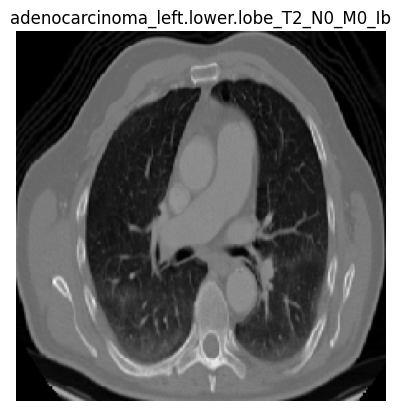

In [4]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# Path to your dataset
data_dir = "/content/Data"

# Function to load images
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))  # Resize to 224x224
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img_array)
                labels.append(label)
    return images, labels

# Load train, validation, and test datasets
train_images, train_labels = load_images_from_folder(os.path.join(data_dir, 'train'))
valid_images, valid_labels = load_images_from_folder(os.path.join(data_dir, 'valid'))
test_images, test_labels = load_images_from_folder(os.path.join(data_dir, 'test'))

# Display one image
plt.imshow(train_images[0] / 255.0)  # Normalize the image
plt.title(train_labels[0])
plt.axis('off')
plt.show()


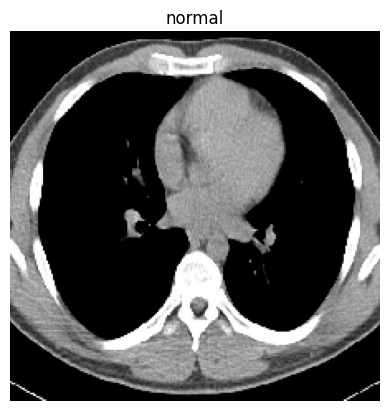

In [5]:
plt.imshow(test_images[0] / 255.0)  # Normalize the image
plt.title(test_labels[0])
plt.axis('off')
plt.show()

In [6]:
train_df = pd.DataFrame({
    'image': train_images,
    'label': train_labels
})

test_df = pd.DataFrame({
    'image': test_images,
    'label': test_labels
})

valid_df = pd.DataFrame({
    'image': valid_images,
    'label': valid_labels
})

In [7]:
train_df.head()

,image,label
0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [1.0, 1.0,...",adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
1,"[[[32.0, 32.0, 32.0], [32.0, 32.0, 32.0], [32....",adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
2,"[[[32.0, 32.0, 32.0], [32.0, 32.0, 32.0], [32....",adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
3,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
4,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib


In [8]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['label'])
valid_df['label'] = label_encoder.transform(valid_df['label'])

In [9]:
train_images = np.array(train_df['image'].tolist()).astype('float32') / 255.0
valid_images = np.array(valid_df['image'].tolist()).astype('float32') / 255.0

train_labels = train_df['label'].values
valid_labels = valid_df['label'].values

In [10]:
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(tr_dir, val_dir, ts_dir):
    # train dataframe
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)

    # validation dataframe
    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)
    # test dataframe
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)
    return train_gen, valid_gen, test_gen
train_dir = '/content/Data/train'
test_dir = '/content/Data/test'
valid_dir = '/content/Data/valid'
train_df, valid_df, test_df = create_df(train_dir, valid_dir, test_dir)

# Get Generators
batch_size = 40
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

Found 613 validated image filenames belonging to 4 classes.
Found 72 validated image filenames belonging to 4 classes.
Found 315 validated image filenames belonging to 4 classes.


# EfficientNetB3

In [10]:
from tensorflow.keras.applications import EfficientNetB3
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze the base model layers
base_model.trainable = False

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
model1 = Sequential([
    base_model,  # EfficientNetB3
    GlobalAveragePooling2D(),  # Add global average pooling
    BatchNormalization(axis=-1),  # Batch normalization
    Dense(256, activation='relu'),  # Dense layer with ReLU activation
    Dropout(0.3),  # Dropout layer for regularization
    Dense(len(np.unique(train_labels)), activation='softmax')  # Output layer
])

In [12]:
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator on your training data
datagen.fit(train_images)

In [14]:
history = model1.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    validation_data=(valid_images, valid_labels),
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 146s 6s/step - accuracy: 0.2913 - loss: 2.0596 - val_accuracy: 0.3194 - val_loss: 1.3868
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 111s 5s/step - accuracy: 0.2778 - loss: 1.9367 - val_accuracy: 0.3194 - val_loss: 1.4410
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 107s 5s/step - accuracy: 0.3563 - loss: 1.8333 - val_accuracy: 0.3194 - val_loss: 1.3511
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 151s 6s/step - accuracy: 0.3175 - loss: 1.8058 - val_accuracy: 0.3194 - val_loss: 1.3691
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 135s 5s/step - accuracy: 0.3099 - loss: 1.6510 - val_accuracy: 0.3194 - val_loss: 1.3748
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 113s 5s/step - accuracy: 0.3234 - loss: 1.6751 - val_accuracy: 0.3889 - val_loss: 1.3658
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 112s 5s/step - accuracy: 0.3270 - loss: 1.7653 - val_accuracy: 0.3194 - val_loss: 1.3587
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 141s 5s/step - accuracy: 0.3783 - loss: 1.5877 - val_accuracy: 0.3750 - val_loss: 1.

In [15]:
train_accuracy = max(history.history['accuracy'])
val_accuracy = max(history.history['val_accuracy'])
print(f"train accuracy {train_accuracy}")
print(f"valid accuracy {val_accuracy}")

train accuracy 0.3572593927383423
valid accuracy 0.4027777910232544


In [16]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 7, 7, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,979,325 (45.70 MB)

 Trainable params: 397,572 (1.52 MB)

 Non-trainable params: 10,786,607 (41.15 MB)

 Optimizer params: 795,146 (3.03 MB)

# INCEPTIONV3

In [13]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
# Assuming train_gen and valid_gen are your image data generators

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained InceptionV3 model
base_model = InceptionV3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis=-1),
    Dense(256, activation='relu'),
    Dropout(0.3),
    # Removed the Reshape layer here
    Dense(class_count, activation='softmax')
])

 # Using Adam optimizer
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

# Define filepath to save the best model
filepath = 'best_model_inceptionv3.keras'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model with the added callback
history = model.fit(
    x=train_gen,
    epochs=10,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4966 - loss: 2.0154
Epoch 1: val_accuracy improved from -inf to 0.30556, saving model to best_model_inceptionv3.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 105s 6s/step - accuracy: 0.4989 - loss: 2.0110 - val_accuracy: 0.3056 - val_loss: 10.2424
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5780 - loss: 1.3001
Epoch 2: val_accuracy did not improve from 0.30556
16/16 ━━━━━━━━━━━━━━━━━━━━ 87s 5s/step - accuracy: 0.5800 - loss: 1.2957 - val_accuracy: 0.1806 - val_loss: 16.6467
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7167 - loss: 0.9446
Epoch 3: val_accuracy improved from 0.30556 to 0.34722, saving model to best_model_inceptionv3.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 89s 6s/step - accuracy: 0.7176 - loss: 0.9395 - val_accuracy: 0.3472 - val_loss: 5.0788
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7572 - loss: 0.6030
Epoch 4: val_accuracy improved from 0.34722 to 0.45833, saving model to best_mode

In [16]:
train_accuracy = max(history.history['accuracy'])
val_accuracy = max(history.history['val_accuracy'])
print(f"train accuracy {train_accuracy}")
print(f"valid accuracy {val_accuracy}")

train accuracy 0.9102773070335388
valid accuracy 0.6388888955116272


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 2048)                │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_94               │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,395,886 (89.25 MB)

 Trainable params: 529,668 (2.02 MB)

 Non-trainable params: 21,806,880 (83.19 MB)

 Optimizer params: 1,059,338 (4.04 MB)